In [1]:
import pandas as pd
import sys
sys.path.append('../')
from scripts.abstract_utils import read_abstracts_file

%load_ext autoreload
%autoreload 2

In [2]:
filename = "../data/abstracts.cat"

abstracts_df = read_abstracts_file(filename)

# Drop rows with missing Cycle
abstracts_df = abstracts_df.dropna(subset=['Cycle'])
abstracts_df = abstracts_df[abstracts_df['Cycle'] != '']

# Convert Cycle and ID to int
abstracts_df['Cycle'] = abstracts_df['Cycle'].astype(int)
abstracts_df['ID'] = abstracts_df['ID'].astype(int)


In [3]:
abstracts_df

,Prop. Type,Category,ID,Cycle,Title,PI,Abstract
0,ENG/STIS/PAR,,10000,12,STIS Pure Parallel Imaging Program: Cycle 12,Paul Goudfrooij,This is the default archival pure parallel pr...
1,GO,GALAXIES,10001,12,Locating Ultraluminous X-Ray Sources,Philip Kaaret,We propose to observe ultraluminous X-ray sou...
2,GO,AGN,10002,12,Detailed Study of X-ray Jets from a Complete S...,Eric Perlman,We propose deep followup HST and Chandra obse...
3,GO,GALAXIES,10003,12,Deep Chandra and Hubble Observations of NGC469...,Craig Sarazin,We propose 4 new Chandra observations of NGC4...
4,GO,AGN,10004,12,The Physics of Relativistic Jets: Chandra Imag...,F. Tavecchio,Extended jets have been a key target for Chan...
...,...,...,...,...,...,...,...
13129,CAL/NIC,,9995,12,Photometric Stability,Mark Dickinson,This NICMOS calibration proposal carries out ...
13130,CAL/NIC,,9996,12,Flats Stability,Alfred Schultz,This calibration proposal is the Cycle 12 NIC...
13131,CAL/NIC,,9997,12,Photometric Recalibration,Mark Dickinson,This proposal extends the NICMOS photometric ...
13132,CAL/NIC,,9998,12,NICMOS Cycle 12 Grism Calibration and Standard...,Ralph Bohlin,This is the grism calibration proposal.


In [4]:
# Only keep specific Cycles

cycle_min = 0
cycle_max = 32

abstracts_cycle_df = abstracts_df[(abstracts_df['Cycle'] >= cycle_min) & (abstracts_df['Cycle'] <= cycle_max)]

In [5]:
# abstract_ids = abstracts_cycle_df['ID'].values
# abstracts_cycle_df['Cycle'].value_counts()

In [6]:
# import os

# def remove_large_files(directory, size_limit=2*1024*1024):  # default size_limit is set to 2MB
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             filepath = os.path.join(foldername, filename)
#             if os.path.getsize(filepath) > size_limit:
#                 try:
#                     os.remove(filepath)
#                     print(f"Removed {filepath}")
#                 except Exception as e:
#                     print(f"Error removing {filepath}: {e}")

# directory_path = '../data/observations/'
# remove_large_files(directory_path)

## Data loader

In [7]:
data_folder = "../data/observations/"

In [8]:
# import os
# import pandas as pd
# from PIL import Image
# import numpy as np

# def get_abstracts_and_images(data_folder, abstracts_cycle_df):
#     # Lists to store results
#     images_list = []
#     abstracts_list = []

#     # Walk through data folder
#     for root, dirs, files in os.walk(data_folder):
#         for file in files:
#             if file.endswith(".jpg"):
#                 image_path = os.path.join(root, file)
#                 proposal_id = root.split("proposal_")[-1]  # Extract proposal id from the directory name
                
#                 # Extract abstract using the dataframe
#                 abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]

#                 image = Image.open(image_path).convert("RGB")
#                 image = np.array(image)

#                 # Pad image to square
#                 h, w, c = image.shape
#                 max_dim = max(h, w)
#                 padded_image = np.ones((max_dim, max_dim, c), dtype=np.uint8) * 255

#                 # Calculate top and left padding
#                 y_offset = (max_dim - h) // 2
#                 x_offset = (max_dim - w) // 2

#                 padded_image[y_offset : y_offset + h, x_offset : x_offset + w, :] = image

#                 images_list.append(padded_image)
#                 abstracts_list.append(abstract)

#     return np.array(abstracts_list), np.array(images_list)

# data_folder = "../data/observations/"
# abstracts, images = get_abstracts_and_images(data_folder, abstracts_cycle_df)

In [9]:
# import tensorflow as tf

# def serialize_example(abstract, image):

#     height, width = image.shape[:2]

#     # Encode abstract to bytes
#     abstract_bytes = abstract.encode('utf-8')  

#     # Convert image to bytes
#     image_bytes = image.tobytes()

#     feature = {
#     'abstract': _bytes_feature(abstract_bytes),
#     'image': _bytes_feature(image_bytes),
#     'image_height': _int64_feature(height),
#     'image_width': _int64_feature(width)
#     }

#     example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example_proto.SerializeToString()

# def _bytes_feature(value):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def _int64_feature(value):
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# with tf.io.TFRecordWriter('../data/observations.tfrecord') as writer:
#     for abstract, image in zip(abstracts, images):
#         example = serialize_example(abstract, image)
#         writer.write(example)

In [10]:
abstracts_cycle_df[abstracts_cycle_df["ID"] == int(9998)]["Category"].values[0]

''

In [11]:
abstracts_cycle_df

,Prop. Type,Category,ID,Cycle,Title,PI,Abstract
0,ENG/STIS/PAR,,10000,12,STIS Pure Parallel Imaging Program: Cycle 12,Paul Goudfrooij,This is the default archival pure parallel pr...
1,GO,GALAXIES,10001,12,Locating Ultraluminous X-Ray Sources,Philip Kaaret,We propose to observe ultraluminous X-ray sou...
2,GO,AGN,10002,12,Detailed Study of X-ray Jets from a Complete S...,Eric Perlman,We propose deep followup HST and Chandra obse...
3,GO,GALAXIES,10003,12,Deep Chandra and Hubble Observations of NGC469...,Craig Sarazin,We propose 4 new Chandra observations of NGC4...
4,GO,AGN,10004,12,The Physics of Relativistic Jets: Chandra Imag...,F. Tavecchio,Extended jets have been a key target for Chan...
...,...,...,...,...,...,...,...
13129,CAL/NIC,,9995,12,Photometric Stability,Mark Dickinson,This NICMOS calibration proposal carries out ...
13130,CAL/NIC,,9996,12,Flats Stability,Alfred Schultz,This calibration proposal is the Cycle 12 NIC...
13131,CAL/NIC,,9997,12,Photometric Recalibration,Mark Dickinson,This proposal extends the NICMOS photometric ...
13132,CAL/NIC,,9998,12,NICMOS Cycle 12 Grism Calibration and Standard...,Ralph Bohlin,This is the grism calibration proposal.


In [60]:
import os
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(abstract, image):

    height, width = image.shape[:2]

    # Encode abstract to bytes
    abstract_bytes = abstract.encode('utf-8')  

    # Convert image to bytes
    image_bytes = image.tobytes()

    feature = {
        'abstract': _bytes_feature(abstract_bytes),
        'image': _bytes_feature(image_bytes),
        'image_height': _int64_feature(height),
        'image_width': _int64_feature(width)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def write_tfrecord(abstracts, images, filename, metadata_file):
    with tf.io.TFRecordWriter(filename) as writer:
        for abstract, image in zip(abstracts, images):
            tf_example = serialize_example(abstract, image)
            writer.write(tf_example)
    
    # Write metadata to the auxiliary file
    with open(metadata_file, 'a') as meta_file:
        meta_file.write(f"{filename}: {len(images)} images\n")

def get_abstracts_and_images_and_write_tfrecords(data_folder, abstracts_cycle_df, num_tfrecords):
    # Lists to store results
    images_list = []
    abstracts_list = []

    # Get the total number of jpg files to be processed for the progress bar
    total_files = sum([len(files) for r, d, files in os.walk(data_folder) if any(file.endswith('.jpg') for file in files)])

    # Calculate the chunk size
    chunk_size = total_files // num_tfrecords if total_files >= num_tfrecords else 1

    print(f"Chunk size is {chunk_size}")

    # Initialize the progress bar
    pbar = tqdm(total=total_files, desc='Processing Images')

    # Initialize the file number
    file_num = 1
    metadata_file = '../data/tfrecords/metadata.txt'
    
    # Clear the metadata file if it exists
    if os.path.exists(metadata_file):
        os.remove(metadata_file)

    # Walk through data folder
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith(".jpg"):
                
                image_path = os.path.join(root, file)
                proposal_id = root.split("proposal_")[-1]  # Extract proposal id from the directory name
                
                # Extract abstract using the dataframe
                abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]
                category = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Category"].values[0]

                if category is not None:
                    abstract = f"Category: {category}. {abstract}"
                    
                image = Image.open(image_path).convert("RGB")
                image = np.array(image)

                # Pad image to square
                h, w, c = image.shape
                max_dim = max(h, w)
                padded_image = np.ones((max_dim, max_dim, c), dtype=np.uint8) * 255

                # Calculate top and left padding
                y_offset = (max_dim - h) // 2
                x_offset = (max_dim - w) // 2

                padded_image[y_offset : y_offset + h, x_offset : x_offset + w, :] = image

                images_list.append(padded_image)
                abstracts_list.append(abstract)
                pbar.update(1)  # Update the progress bar

                # If the length of the lists reaches the chunk size, write to a TFRecord file
                if len(images_list) >= chunk_size:
                    print(f"Writing record {file_num}")
                    filename = f"../data/tfrecords/observations_{file_num}.tfrecord"
                    write_tfrecord(abstracts_list, images_list, filename, metadata_file)
                    images_list = []
                    abstracts_list = []
                    file_num += 1  # Increment the file number

    # Write the remaining records to a TFRecord file if any
    if images_list:
        print(f"Writing final record {num_tfrecords}")
        filename = f"tfrecord_{file_num}.tfrecord"
        write_tfrecord(abstracts_list, images_list, filename, metadata_file)

    pbar.close()  # Close the progress bar

data_folder = "../data/observations/"
num_tfrecords = 10
get_abstracts_and_images_and_write_tfrecords(data_folder, abstracts_cycle_df, num_tfrecords)

Chunk size is 3185


Processing Images:   0%|          | 0/31859 [00:00<?, ?it/s]

Writing record 1
Writing record 2
Writing record 3
Writing record 4
Writing record 5
Writing record 6
Writing record 7
Writing record 8
Writing record 9
Writing record 10
Writing final record 10


In [12]:
from absl import logging
logging.set_verbosity(logging.INFO)

INFO:absl:Using 4016 examples in dataset


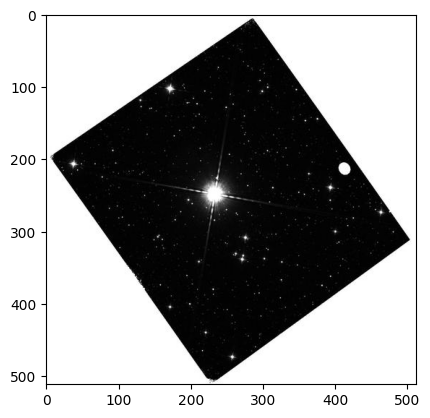

In [33]:
import sys
sys.path.append("../")

from models.dataset_utils import make_dataloader, create_input_iter

# files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord',]
files = ['../data/observations.tfrecord',]
ds = make_dataloader(files, batch_size=32, seed=42)
create_input_iter(ds)

image, caption = next(iter(ds))

import matplotlib.pyplot as plt
plt.imshow(image[0], vmin=0, vmax=1)

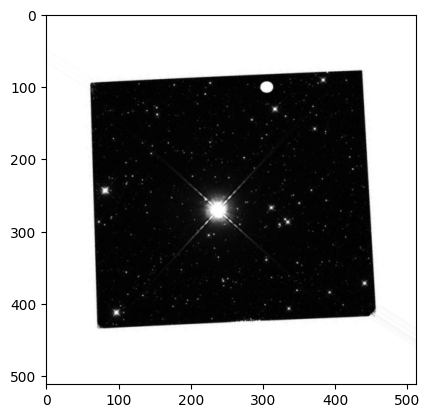

In [34]:
from dm_pix import rotate
import jax
import jax.numpy as jnp
from functools import partial

plt.imshow(jax.vmap(partial(rotate, cval=0.))(jnp.array(image), jnp.ones(32) * 1.)[0])

In [35]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [37]:
image, caption = next(iter(ds))

In [38]:
caption = caption.numpy().tolist()
caption = [c.decode('utf-8') for c in caption]

tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=300,
            return_tensors="np",
        )

{'input_ids': array([[49406, 20564, 20392, ..., 10128,  3687, 49407],
       [49406, 18304, 25810, ...,   537,   325, 49407],
       [49406, 28359,  4879, ...,   320, 19631, 49407],
       ...,
       [49406,  2510,  5357, ..., 49407, 49407, 49407],
       [49406,   589,  2737, ...,   601,  1348, 49407],
       [49406, 42280, 32435, ...,  4832, 33521, 49407]]), 'attention_mask': array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])}